<a href="https://colab.research.google.com/github/Aleena24/SpeechProcessing/blob/main/timeAlignmentNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Two speech sequences

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [22]:
# Define the signals
signal_1 = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2])  # Reference signal
signal_2 = np.array([0.2, 0.3, 0.5, 0.7, 0.9, 1.0, 0.9, 0.7, 0.5, 0.4, 0.3, 0.2])  # Test signal

# Lengths of signals
len_signal_1 = len(signal_1)
len_signal_2 = len(signal_2)

print(f"Length of Signal 1: {len_signal_1}")
print(f"Length of Signal 2: {len_signal_2}")

Length of Signal 1: 9
Length of Signal 2: 12


## (a) Plot both speech signals

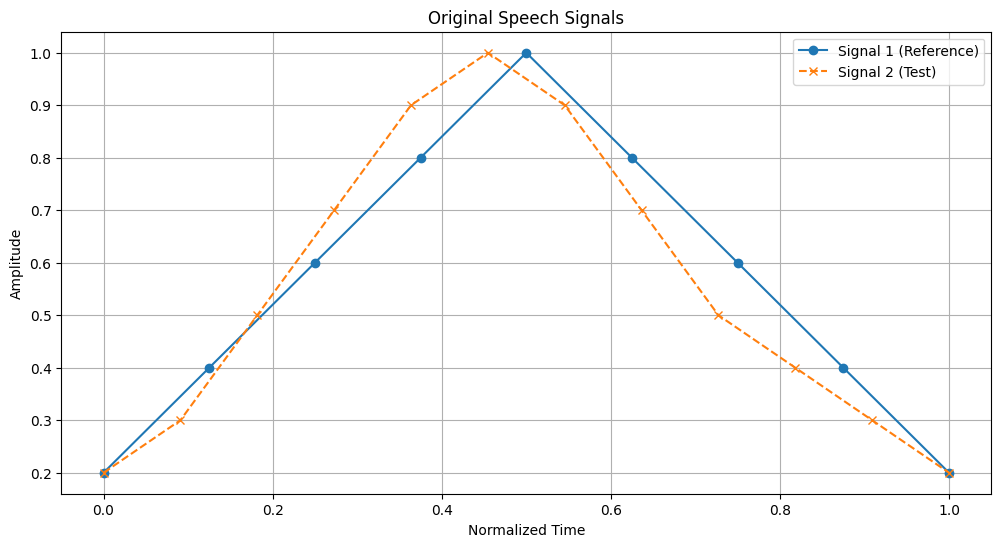

In [17]:
time_signal_1 = np.linspace(0, 1, len_signal_1)
time_signal_2 = np.linspace(0, 1, len_signal_2)

plt.figure(figsize=(12, 6))
plt.plot(time_signal_1, signal_1, label="Signal 1 (Reference)", marker='o')
plt.plot(time_signal_2, signal_2, label="Signal 2 (Test)", marker='x', linestyle='--')
plt.title("Original Speech Signals")
plt.xlabel("Normalized Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

## (b) Perform Linear Time Normalization

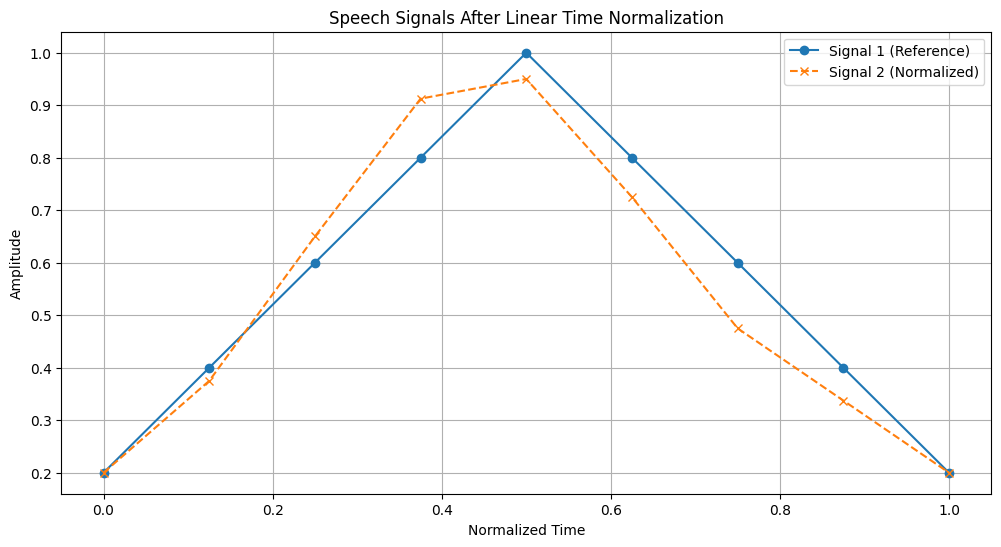

In [18]:
time_signal_2_normalized = np.linspace(0, 1, len_signal_1)  # Normalized to match length of Signal 1
interp_func = interp1d(time_signal_2, signal_2, kind='linear')  # Linear interpolation
signal_2_normalized = interp_func(time_signal_2_normalized)

# Plot normalized signals
plt.figure(figsize=(12, 6))
plt.plot(time_signal_1, signal_1, label="Signal 1 (Reference)", marker='o')
plt.plot(time_signal_2_normalized, signal_2_normalized, label="Signal 2 (Normalized)", marker='x', linestyle='--')
plt.title("Speech Signals After Linear Time Normalization")
plt.xlabel("Normalized Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

## (c) Compute alignment

In [24]:
alignment_cost = np.sum((signal_1 - signal_2_normalized)**2) / len_signal_1
print(f"Alignment Cost between Signal 1 and normalized Signal 2 (MSE): {alignment_cost}")

Alignment Cost between Signal 1 and normalized Signal 2 (MSE): 0.00482638888888889


## (d) Plot the alignment path

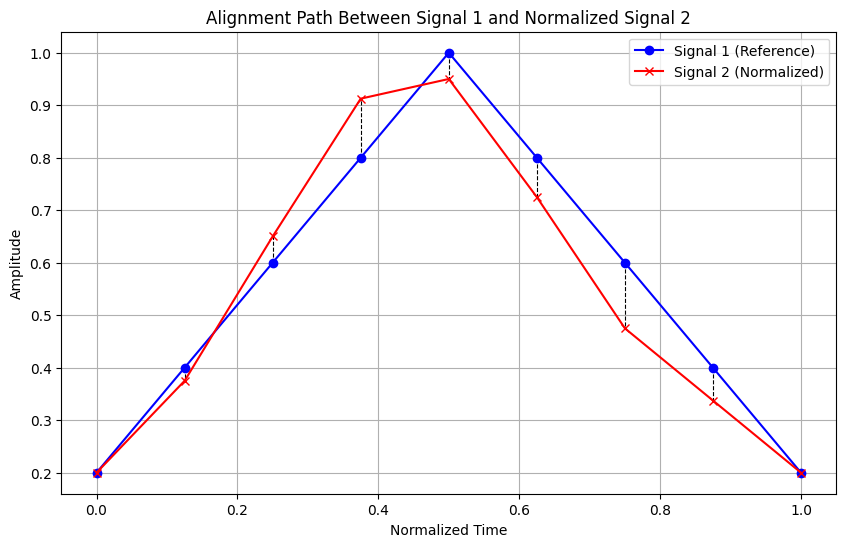

In [20]:
plt.figure(figsize=(10, 6))
for i in range(len_signal_1):
    plt.plot([i / (len_signal_1 - 1), i / (len_signal_1 - 1)],
             [signal_1[i], signal_2_normalized[i]], 'k--', linewidth=0.8)

# Overlay signals for reference
plt.plot(np.linspace(0, 1, len_signal_1), signal_1, 'bo-', label="Signal 1 (Reference)")
plt.plot(np.linspace(0, 1, len_signal_1), signal_2_normalized, 'rx-', label="Signal 2 (Normalized)")

plt.title("Alignment Path Between Signal 1 and Normalized Signal 2")
plt.xlabel("Normalized Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# (e) Linear Time Normalization


LTN rescaled Signal 2 to match the length of Signal 1.
The alignment cost 0.0048 indicates the signals are closely aligned.
LTN assumes uniform stretching, so it works well for this example but may fail in cases with non-linear variations.